# LDA prediction from CODEX data

In [3]:
import scimap as sm
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import pandas as pd
import logging
from sklearn.neighbors import BallTree
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
def spatial_lda_internal (adata_subset, x_coordinate,y_coordinate,z_coordinate,phenotype, 
                              method, radius, knn, imageid):
        
        # Print which image is being processed
        print('Processing: ' + str(np.unique(adata_subset.obs[imageid])))
        
        
        # Create a dataFrame with the necessary inforamtion
        if z_coordinate is not None:
            if verbose:
                print("Including Z -axis")
            data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'z': adata_subset.obs[z_coordinate], 'phenotype': adata_subset.obs[phenotype]})
        else:
            data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'phenotype': adata_subset.obs[phenotype]})

        
        # Create a DataFrame with the necessary inforamtion
        #data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'phenotype': adata_subset.obs[phenotype]})
        
        # Identify neighbourhoods based on the method used
        # a) KNN method
        
        if method == 'knn':
            print("Identifying the " + str(knn) + " nearest neighbours for every cell")
            if z_coordinate is not None:
                tree = BallTree(data[['x','y','z']], leaf_size= 2)
                ind = tree.query(data[['x','y','z']], k=knn, return_distance= False)
            else:
                tree = BallTree(data[['x','y']], leaf_size= 2)
                ind = tree.query(data[['x','y']], k=knn, return_distance= False)
            ind = list(np.array(item) for item in ind)
                

        # b) Local radius method
        if method == 'radius':
            print("Identifying neighbours within " + str(radius) + " pixels of every cell")
            if z_coordinate is not None:
                kdt = BallTree(data[['x','y','z']], metric='euclidean') 
                ind = kdt.query_radius(data[['x','y','z']], r=radius, return_distance=False)
            else:
                kdt = BallTree(data[['x','y']], metric='euclidean') 
                ind = kdt.query_radius(data[['x','y']], r=radius, return_distance=False)

        # Map phenotype
        phenomap = dict(zip(list(range(len(ind))), data['phenotype'])) # Used for mapping
        for i in range(len(ind)):
            ind[i] = [phenomap[letter] for letter in ind[i]]
            
        # return
        return ind

In [3]:
codex = ad.read_h5ad("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/code/CD_analysis/aSMA_CD21_analysis/all_regions_dat.h5ad")
codex

AnnData object with n_obs × n_vars = 3895114 × 38
    obs: 'Unnamed: 0', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Reg', 'Tile.Row', 'Tile.Col', 'Tile.Z', 'In.Tile.Y', 'In.Tile.X', 'Absolute.Y', 'Absolute.X', 'Cell.Size', 'n_genes_by_counts', 'total_counts', 'nCount_raw', 'nFeature_raw', 'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'motif', 'index_info', 'new_pheno', 'region'
    uns: 'lda_10', 'lda_10_probability', 'lda_12', 'lda_12_probability', 'lda_15', 'lda_15_probability', 'lda_8', 'lda_8_probability', 'spatial_lda', 'spatial_lda_probability'

In [79]:
codex.obs['new_pheno'].unique().to_list()

/tmp/ipykernel_1452185/3704539455.py:1: FutureWarning:

Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead



['CD4_T_Cell',
 'CD8_T_Cell',
 'Lymphatics',
 'Treg',
 'Cytotoxic_T_Cell',
 'Endothelial',
 'Macrophage',
 'B_Cell',
 'Plasma_Cell',
 'Neutrophil',
 'pDC',
 'Stromal',
 'T_cell',
 'cDC2',
 'myeloid',
 'immune',
 'Tfh',
 'cDC1',
 'Mast_Cell']

In [80]:
adata.obs.ct_codex.unique().tolist()

['Stromal',
 'CD4_T_Cell',
 'B_Cell',
 'Lymphatics',
 'Endothelial',
 'pDC',
 'Tfh',
 'Macrophage',
 'CD8_T_Cell',
 'Plasma_Cell',
 'cDC2',
 'cDC1',
 'Treg',
 'immune',
 'Neutrophil']

In [4]:
adata_list = [codex[codex.obs['region'] == i] for i in codex.obs['region'].unique()]

# The LDA function

In [83]:
r_spatial_lda_internal = lambda x: spatial_lda_internal(adata_subset=x,
                                                            x_coordinate='Absolute.X',
                                                            y_coordinate='Absolute.Y',
                                                        z_coordinate=None,
                                                            phenotype='new_pheno', 
                                                            method='radius', 
                                                            radius=50, 
                                                            knn=None, 
                                                            imageid='region') 

In [84]:
all_data = list(map(r_spatial_lda_internal, adata_list))

Processing: ['MCD1_reg1']
Identifying neighbours within 50 pixels of every cell
Processing: ['MCD3_reg2']
Identifying neighbours within 50 pixels of every cell
Processing: ['MCD1_reg3']
Identifying neighbours within 50 pixels of every cell
Processing: ['HVCD2_reg1']
Identifying neighbours within 50 pixels of every cell
Processing: ['R1_reg3']
Identifying neighbours within 50 pixels of every cell
Processing: ['MCD4_reg3']
Identifying neighbours within 50 pixels of every cell
Processing: ['R2_reg1']
Identifying neighbours within 50 pixels of every cell
Processing: ['HVCD1_reg3']
Identifying neighbours within 50 pixels of every cell
Processing: ['HVCD2_reg3']
Identifying neighbours within 50 pixels of every cell
Processing: ['MCD3_reg1']
Identifying neighbours within 50 pixels of every cell
Processing: ['HVCD1_reg1']
Identifying neighbours within 50 pixels of every cell
Processing: ['MCD4_reg1']
Identifying neighbours within 50 pixels of every cell
Processing: ['MCD4_reg2']
Identifying ne

In [85]:
texts = np.concatenate( all_data, axis=0 ).tolist()
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

In [23]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=12, 
                                                   random_state=0)

In [25]:
# latent features
topic_weights = []
for row_list in lda_model[corpus]:
    tmp = np.zeros(12)
    for i, w in row_list:
        tmp[i] = w
    topic_weights.append(tmp)
# conver to dataframe
arr = pd.DataFrame(topic_weights, index=codex.obs.index).fillna(0)
arr = arr.add_prefix('Motif_')

In [30]:
arr.head()

,Motif_0,Motif_1,Motif_2,Motif_3,Motif_4,Motif_5,Motif_6,Motif_7,Motif_8,Motif_9,Motif_10,Motif_11
56787_MCD1_reg1,0.0,0.498313,0.0,0.437581,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
56788_MCD1_reg1,0.0,0.814609,0.0,0.000000,0.0,0.0,0.0,0.0,0.129834,0.0,0.0,0.0
56790_MCD1_reg1,0.0,0.831702,0.0,0.000000,0.0,0.0,0.0,0.0,0.122000,0.0,0.0,0.0
56793_MCD1_reg1,0.0,0.946076,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
56798_MCD1_reg1,0.0,0.949072,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [27]:
# isolate the weights of phenotypes
pattern = "(\d\.\d+).\"(.*?)\""
cell_weight = pd.DataFrame(index=np.unique(codex.obs['new_pheno']))
for i in range(0, len(lda_model.print_topics())):
    level1 = lda_model.print_topics()[i][1]
    tmp = pd.DataFrame(re.findall(pattern, level1))
    tmp.index = tmp[1]
    tmp = tmp.drop(columns=1)
    tmp.columns = ['Motif_'+ str(i)]
    cell_weight = cell_weight.merge(tmp, how='outer', left_index=True, right_index=True)
# fill zeros
cell_weight = cell_weight.fillna(0).astype(float)

In [28]:
cell_weight

,Motif_0,Motif_1,Motif_2,Motif_3,Motif_4,Motif_5,Motif_6,Motif_7,Motif_8,Motif_9,Motif_10,Motif_11
B_Cell,0.429,0.051,0.400,0.100,0.779,0.163,0.193,0.061,0.058,0.209,0.061,0.258
CD4_T_Cell,0.158,0.449,0.214,0.164,0.036,0.142,0.314,0.065,0.174,0.385,0.105,0.110
CD8_T_Cell,0.035,0.063,0.108,0.060,0.019,0.138,0.079,0.076,0.082,0.250,0.042,0.047
Cytotoxic_T_Cell,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.006
Endothelial,0.176,0.186,0.025,0.075,0.020,0.030,0.058,0.214,0.283,0.019,0.046,0.067
Lymphatics,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.011,0.000,0.014,0.005,0.000
Macrophage,0.071,0.141,0.063,0.310,0.036,0.104,0.096,0.163,0.165,0.080,0.124,0.071
Mast_Cell,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Neutrophil,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.008,0.000,0.000,0.000
Plasma_Cell,0.022,0.023,0.000,0.199,0.003,0.000,0.069,0.363,0.174,0.000,0.585,0.009


In [29]:
codex.uns['lda_12_probability']

,Motif_0,Motif_1,Motif_2,Motif_3,Motif_4,Motif_5,Motif_6,Motif_7,Motif_8,Motif_9,Motif_10,Motif_11
B_Cell,0.358,0.050,0.835,0.109,0.402,0.078,0.178,0.036,0.056,0.232,0.041,0.186
CD4_T_Cell,0.151,0.608,0.066,0.213,0.017,0.260,0.348,0.039,0.199,0.351,0.093,0.089
CD8_T_Cell,0.031,0.127,0.025,0.113,0.014,0.426,0.153,0.031,0.131,0.000,0.050,0.038
Cytotoxic_T_Cell,0.007,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.017
Endothelial,0.240,0.064,0.006,0.029,0.046,0.008,0.023,0.458,0.374,0.265,0.054,0.036
Lymphatics,0.000,0.011,0.000,0.029,0.000,0.000,0.000,0.007,0.000,0.000,0.006,0.000
Macrophage,0.065,0.093,0.020,0.393,0.034,0.054,0.083,0.325,0.118,0.135,0.124,0.041
Mast_Cell,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Neutrophil,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.020,0.000,0.000,0.000
Plasma_Cell,0.007,0.000,0.000,0.021,0.000,0.000,0.006,0.066,0.038,0.002,0.599,0.000


In [ ]:
# r = "R1_reg1"
# test = codex[codex.obs['region']==r,:].copy()
# test = test[1:1000,]
# fig, ax = plt.subplots(figsize=(10,10))
# sm.pl.voronoi(test, x_coordinate='Absolute.X', y_coordinate='Absolute.Y', 
#               color_by = 'motif', imageid='orig.ident',voronoi_edge_color='white', voronoi_line_width=0, **{'ax':ax},
#              )

In [32]:
temp_file = datapath("codex_LDA_12topic")
lda_model.save(temp_file)

## Update model on Xenium data

how does radus of 50 in CODEX translate to Xenium?
In CODEX, it's about 12-20

I think I need to better match the xenium cell type names to codex

In [86]:
temp_file = datapath("codex_LDA_12topic")
lda_model = gensim.models.ldamodel.LdaModel.load(temp_file)

In [18]:
def spatial_lda_internal (adata_subset, x_coordinate,y_coordinate,z_coordinate,phenotype, 
                              method, radius, knn, imageid):
        
        # Print which image is being processed
        print('Processing: ' + str(np.unique(adata_subset.obs[imageid])))
        
        
        # Create a dataFrame with the necessary inforamtion
        if z_coordinate is not None:
            if verbose:
                print("Including Z -axis")
            data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'z': adata_subset.obs[z_coordinate], 'phenotype': adata_subset.obs[phenotype]})
        else:
            data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'phenotype': adata_subset.obs[phenotype]})

        
        # Create a DataFrame with the necessary inforamtion
        #data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'phenotype': adata_subset.obs[phenotype]})
        
        # Identify neighbourhoods based on the method used
        # a) KNN method
        
        if method == 'knn':
            print("Identifying the " + str(knn) + " nearest neighbours for every cell")
            if z_coordinate is not None:
                tree = BallTree(data[['x','y','z']], leaf_size= 2)
                ind = tree.query(data[['x','y','z']], k=knn, return_distance= False)
            else:
                tree = BallTree(data[['x','y']], leaf_size= 2)
                ind = tree.query(data[['x','y']], k=knn, return_distance= False)
            ind = list(np.array(item) for item in ind)
                

        # b) Local radius method
        if method == 'radius':
            print("Identifying neighbours within " + str(radius) + " pixels of every cell")
            if z_coordinate is not None:
                kdt = BallTree(data[['x','y','z']], metric='euclidean') 
                ind = kdt.query_radius(data[['x','y','z']], r=radius, return_distance=False)
            else:
                kdt = BallTree(data[['x','y']], metric='euclidean') 
                ind = kdt.query_radius(data[['x','y']], r=radius, return_distance=False)

        # Map phenotype
        phenomap = dict(zip(list(range(len(ind))), data['phenotype'])) # Used for mapping
        for i in range(len(ind)):
            ind[i] = [phenomap[letter] for letter in ind[i]]
            
        # return
        return ind

In [17]:
adata = ad.read_h5ad("xenium_filter_annotated.h5ad")

In [102]:
np.median([len(c) for c in all_data[1]])

15.0

In [46]:
dat = spatial_lda_internal(adata_subset=adata[adata.obs.core_id == '4',:],
                                                            x_coordinate='X_centroid',
                                                            y_coordinate='Y_centroid',
                                                        z_coordinate=None,
                                                            phenotype='ct_codex', 
                                                            method='radius', 
                                                            radius=15, 
                                                            knn=None, 
                                                            imageid='core_id') 

Processing: ['4']
Identifying neighbours within 15 pixels of every cell


In [113]:
np.median([len(c) for c in dat])

14.0

In [52]:
xen_spatial_lda_internal = lambda x: spatial_lda_internal(adata_subset=x,
                                                            x_coordinate='X_centroid',
                                                            y_coordinate='Y_centroid',
                                                        z_coordinate=None,
                                                            phenotype='ct_codex', 
                                                            method='radius', 
                                                            radius=15, 
                                                            knn=None, 
                                                            imageid='core_id') 

In [50]:
xendata_list = [adata[adata.obs['core_id'] == i] for i in adata.obs['core_id'].unique()]

In [53]:
all_xdata = list(map(xen_spatial_lda_internal, xendata_list))

Processing: ['16']
Identifying neighbours within 15 pixels of every cell
Processing: ['7']
Identifying neighbours within 15 pixels of every cell
Processing: ['1']
Identifying neighbours within 15 pixels of every cell
Processing: ['13']
Identifying neighbours within 15 pixels of every cell
Processing: ['14']
Identifying neighbours within 15 pixels of every cell
Processing: ['4']
Identifying neighbours within 15 pixels of every cell
Processing: ['8']
Identifying neighbours within 15 pixels of every cell
Processing: ['18']
Identifying neighbours within 15 pixels of every cell
Processing: ['2']
Identifying neighbours within 15 pixels of every cell
Processing: ['5']
Identifying neighbours within 15 pixels of every cell
Processing: ['17']
Identifying neighbours within 15 pixels of every cell
Processing: ['9']
Identifying neighbours within 15 pixels of every cell
Processing: ['3']
Identifying neighbours within 15 pixels of every cell
Processing: ['33']
Identifying neighbours within 15 pixels 

In [120]:
id2word[3]

'Macrophage'

In [87]:
texts = np.concatenate( all_xdata, axis=0 ).tolist()
# id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

In [105]:
all_xdata[0][0]

['CD4_T_Cell',
 'Lymphatics',
 'B_Cell',
 'B_Cell',
 'Stromal',
 'Stromal',
 'B_Cell',
 'Stromal',
 'Stromal',
 'Endothelial',
 'CD4_T_Cell']

In [106]:
lda_model[corpus[0]]

[(9, 0.20064613), (11, 0.72990656)]

In [107]:
# to update model...

lda_model.update(corpus)

In [108]:
topic_weights = []
for row_list in lda_model[corpus]:
    tmp = np.zeros(12)
    for i, w in row_list:
        tmp[i] = w
    topic_weights.append(tmp)
# convert to dataframe
arr = pd.DataFrame(topic_weights, index=adata.obs.index).fillna(0)
arr = arr.add_prefix('Motif_')
adata.uns['codex_LDApred'] = arr

In [109]:
adata = sm.tl.spatial_cluster(adata, df_name='codex_LDApred', 
                                       method='kmeans', k=12, label='spatial_lda_kmeans')

Kmeans clustering


In [110]:
pattern = "(\d\.\d+).\"(.*?)\""
cell_weight = pd.DataFrame(index=np.unique(adata.obs['ct_codex']))
for i in range(0, len(lda_model.print_topics())):
    level1 = lda_model.print_topics()[i][1]
    tmp = pd.DataFrame(re.findall(pattern, level1))
    tmp.index = tmp[1]
    tmp = tmp.drop(columns=1)
    tmp.columns = ['Motif_'+ str(i)]
    cell_weight = cell_weight.merge(tmp, how='outer', left_index=True, right_index=True)
# fill zeros
cell_weight = cell_weight.fillna(0).astype(float)
adata.uns['codex_LDApred_probability'] = cell_weight

In [111]:
motif_names = adata.uns['codex_LDApred'].columns
adata.obs['motif'] = adata.uns['codex_LDApred'].apply(lambda x: motif_names[np.argmax(x)], axis=1)

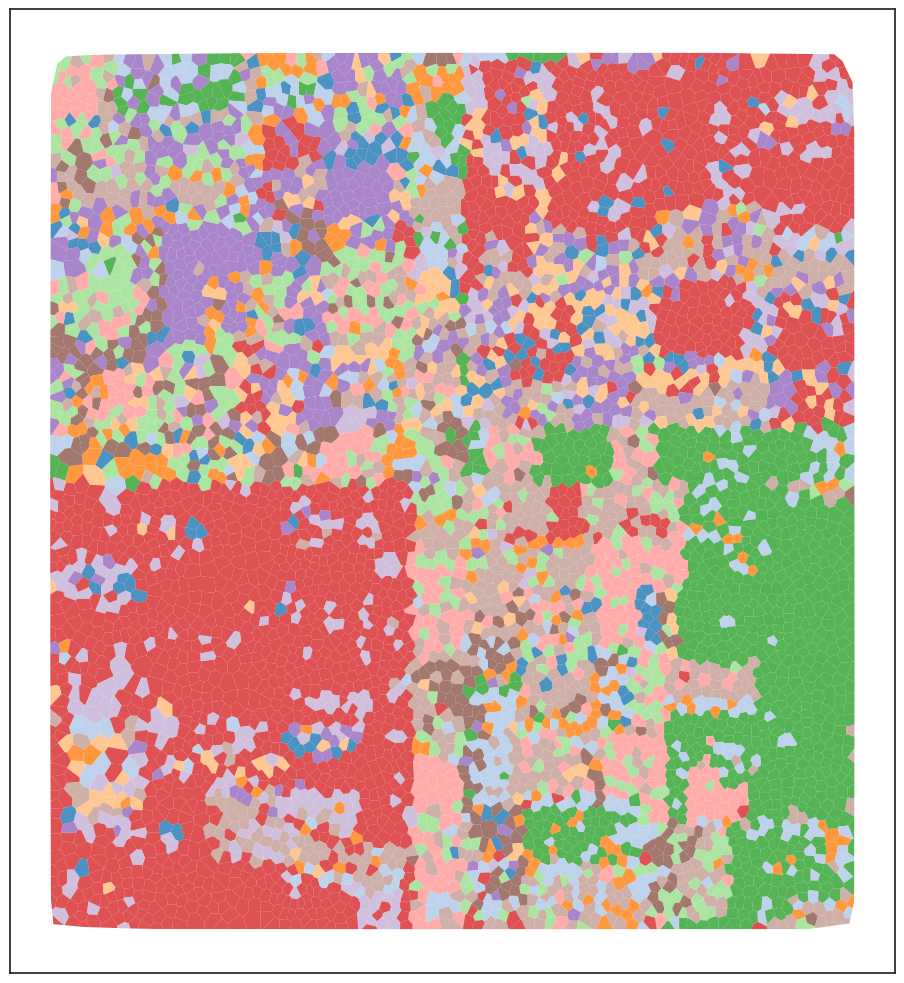

In [112]:
fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(adata, x_lim = [8000,8500], y_lim=[4000,4500], 
              color_by='spatial_lda_kmeans', 
              x_coordinate='X_centroid', y_coordinate='Y_centroid',
              imageid='core_id', subset='35',
                 voronoi_edge_color = 'black',
                 voronoi_line_width = 0, 
                 voronoi_alpha = 0.8, 
                 size_max=3000,
                 overlay_points=None, 
                 plot_legend=True, 
                 legend_size=6, **{'ax':ax})

In [95]:
adata.write_h5ad("xenium_filter_annotated.h5ad")

### Trying orthogonal approach, spatial count clustering

I can't figure out why the LDA model isn't working on the xenium data...
trying scimap spatial count clustering

In [122]:
# finally! I have this sorted out
bad_cores = ['20','21','22','6','29','28','12','10','11','31','32','30','15']
sample_dict = {
    '2':['19','3'],
    '3':['1','2'],
    '4':['23','24'],
    '6':['5','4'],
    '7':['27','26'],
    '8':['25','9'],
    '9':['7','8'],
    '15':['13','14'],
    '16':['35','34'],
    '17':['33','17'],
    '18':['16'],
    '19':['38','37'],
    '20':['36','18']
}
MCDi = ['2','3','6','7','9','15','16','17','19']
RLNi = ['4','8']
UCDi = ['18','20']

In [123]:

# adding some new annotations
adata.obs['sample_id'] = 'unknown'
for key, value in sample_dict.items():
    adata.obs['sample_id'].loc[adata.obs.core_id.isin(value)] = key
    
adata.obs['disease'] = 'unknown'
adata.obs['disease'].loc[adata.obs.sample_id.isin(MCDi)] = 'MCD'
adata.obs['disease'].loc[adata.obs.sample_id.isin(RLNi)] = 'RLN'
adata.obs['disease'].loc[adata.obs.sample_id.isin(UCDi)] = 'UCD'
# len(keep_i)

/tmp/ipykernel_1452185/2027219432.py:4: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_1452185/2027219432.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

In [126]:
adata.obs['slide'] = 1
sid = adata.obs.sample_id.astype('int')
adata.obs['slide'].loc[sid < 19] = 2

/tmp/ipykernel_1452185/1340194681.py:3: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_1452185/1340194681.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

In [128]:
adata = sm.tl.spatial_count(adata, x_coordinate='X_centroid', y_coordinate='Y_centroid', z_coordinate=None, 
                      phenotype='ct_codex', method='radius', radius=15, imageid='slide', subset=None, 
                      verbose=True, label='spatial_count')


Identifying neighbours within 15 pixels of every cell
Identifying neighbours within 15 pixels of every cell


In [133]:
adata.uns['spatial_count']

neighbour_phenotype,B_Cell,CD4_T_Cell,CD8_T_Cell,Endothelial,Lymphatics,Macrophage,Neutrophil,Plasma_Cell,Stromal,Tfh,Treg,cDC1,cDC2,immune,pDC
aaaaaocf-1-0,0.448276,0.137931,0.000000,0.034483,0.068966,0.000000,0.0,0.0,0.275862,0.0,0.0,0.0,0.0,0.034483,0.0
aaaabbjh-1-0,0.343750,0.187500,0.031250,0.031250,0.062500,0.031250,0.0,0.0,0.281250,0.0,0.0,0.0,0.0,0.031250,0.0
aaaacchj-1-0,0.281250,0.250000,0.062500,0.031250,0.093750,0.062500,0.0,0.0,0.187500,0.0,0.0,0.0,0.0,0.031250,0.0
aaaacdao-1-0,0.296296,0.296296,0.037037,0.000000,0.074074,0.074074,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.000000,0.0
aaaaclmo-1-0,0.310345,0.275862,0.034483,0.034483,0.034483,0.034483,0.0,0.0,0.241379,0.0,0.0,0.0,0.0,0.034483,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oiandiom-1-1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
oiandnhk-1-1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
oianekke-1-1,0.933333,0.000000,0.000000,0.000000,0.000000,0.066667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
oianglph-1-1,0.928571,0.000000,0.000000,0.000000,0.000000,0.071429,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [129]:
adata = sm.tl.spatial_cluster(adata, df_name='spatial_count', method='kmeans', k=12, label='cluster_kmeans_scimap')

Kmeans clustering


In [4]:
adata = ad.read_h5ad("xenium_filter_annotated_checkpoint.h5ad")

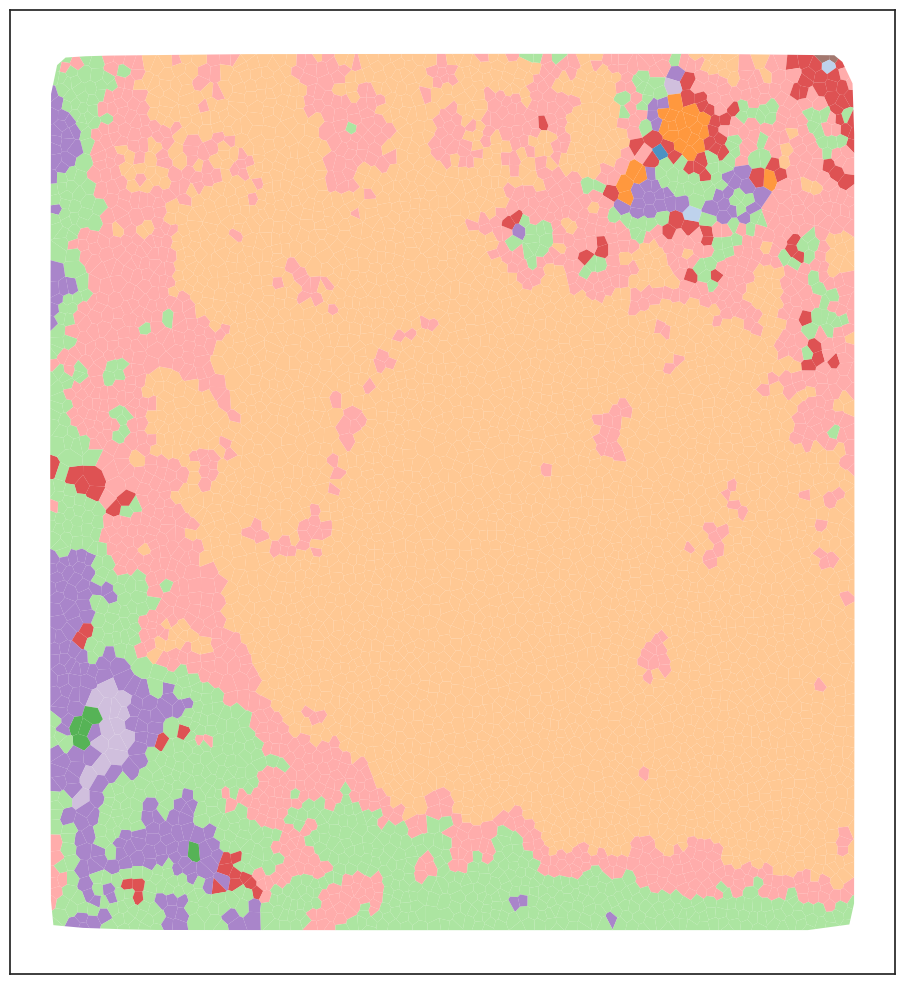

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(adata, x_lim = [8000,8500], y_lim=[4000,4500], 
              color_by='cluster_kmeans_scimap', 
              x_coordinate='X_centroid', y_coordinate='Y_centroid',
              imageid='core_id', subset='35',
                 voronoi_edge_color = 'black',
                 voronoi_line_width = 0, 
                 voronoi_alpha = 0.8, 
                 size_max=3000,
                 overlay_points=None, 
                 plot_legend=True, 
                 legend_size=6, **{'ax':ax})

In [134]:
# can I just match these up to the original proportions?

pdata = adata.uns['spatial_count']
pdata['motif'] = adata.obs['cluster_kmeans_scimap']
pdata = pdata.groupby('motif').agg('sum')
pdata

neighbour_phenotype,B_Cell,CD4_T_Cell,CD8_T_Cell,Endothelial,Lymphatics,Macrophage,Neutrophil,Plasma_Cell,Stromal,Tfh,Treg,cDC1,cDC2,immune,pDC
motif,,,,,,,,,,,,,,,
0,16187.624154,23381.598659,15088.103155,4777.231234,9317.833427,32901.655387,25.480926,7281.494367,14248.890250,1351.326644,277.215384,856.389122,237.572600,893.188956,3629.395735
1,1664.000837,2069.976524,2421.504177,2311.591923,259.558619,3525.289552,0.709074,58816.541631,4127.169909,48.044906,24.818912,65.543698,8.676808,23.765849,269.807582
10,13008.936982,17286.815383,6678.651647,5441.377544,3727.421545,9255.354178,14.140401,6306.073063,40371.606957,935.483512,127.942719,523.630879,129.250822,324.024644,2101.289724
11,4766.947431,8615.296288,4590.149116,17857.830854,2571.886637,3980.187953,23.953104,3188.801752,6964.364089,450.579792,53.476955,168.643450,38.932409,278.632774,831.317396
2,293245.215069,8403.768474,2634.093109,887.214797,383.237727,1807.199721,1.061872,1123.383695,3842.333625,419.286732,77.485543,74.078083,12.854386,218.994696,297.792471
3,14946.893143,146102.194748,12134.017745,2782.978573,1501.576305,8552.223195,23.900088,3346.948424,9633.230349,1825.917377,464.921237,496.017705,495.596636,423.607941,2293.976534
4,125704.089600,69217.015499,11870.699503,3138.074222,2437.602037,8260.517204,16.675043,4025.017792,10294.599078,1412.503069,329.127864,520.604479,198.938727,944.075608,2344.460275
5,96130.342079,27104.581753,15110.828932,7812.311647,6634.934496,16054.762227,26.867928,21531.401705,25490.561091,1539.114785,323.293057,752.362013,188.639609,1138.302728,3513.695951
6,218486.021035,35014.330624,10398.480583,4979.618205,3091.507977,10285.143719,19.386924,8030.898367,15799.562732,1371.231613,273.931185,476.687616,109.463670,1016.246561,2439.489188


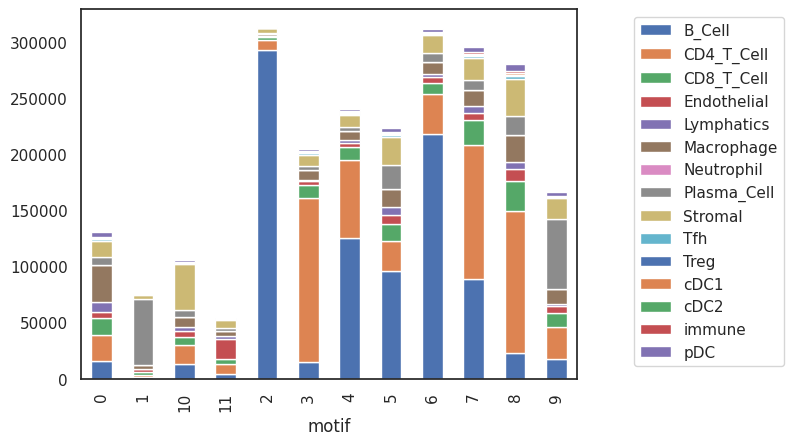

In [139]:
fig = plt.figure()
ax = plt.subplot(111)

pdata.plot.bar(stacked=True, **{'ax':ax})
ax.legend(bbox_to_anchor=(1.1, 1))
plt.show()

In [140]:
# trying all new LDA, match motif compositions?
adata = sm.tl.spatial_lda(adata, x_coordinate='X_centroid', y_coordinate='Y_centroid',
                    method='radius', radius=15, num_motifs=12, imageid='slide', phenotype='ct_codex',
                    label='lda_radius_15')


Processing: [2]
Identifying neighbours within 15 pixels of every cell
Processing: [1]
Identifying neighbours within 15 pixels of every cell
Pre-Processing Spatial LDA
Training Spatial LDA
Calculating the Coherence Score

Coherence Score:  0.41231949028223885
Gathering the latent weights


In [141]:
adata.uns['spatial_lda'].head()

,Motif_0,Motif_1,Motif_2,Motif_3,Motif_4,Motif_5,Motif_6,Motif_7,Motif_8,Motif_9,Motif_10,Motif_11
aaaaaocf-1-0,0.000000,0.0,0.0,0.300878,0.000000,0.0,0.0,0.0,0.164350,0.466587,0.0,0.0
aaaabbjh-1-0,0.612616,0.0,0.0,0.000000,0.311623,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
aaaacchj-1-0,0.000000,0.0,0.0,0.511201,0.413038,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
aaaacdao-1-0,0.313549,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.264973,0.353293,0.0,0.0
aaaaclmo-1-0,0.663419,0.0,0.0,0.260819,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [148]:
# adata = sm.tl.spatial_cluster(adata, df_name='spatial_lda', method='phenograph', 
#                               phenograph_clustering_metric='manhattan', nearest_neighbors=15, label='cluster_phenograph')
adata = sm.tl.spatial_cluster(adata, df_name='spatial_lda', method='kmeans', 
                              nearest_neighbors=12, label='cluster_kmeans_new_lda')


Kmeans clustering


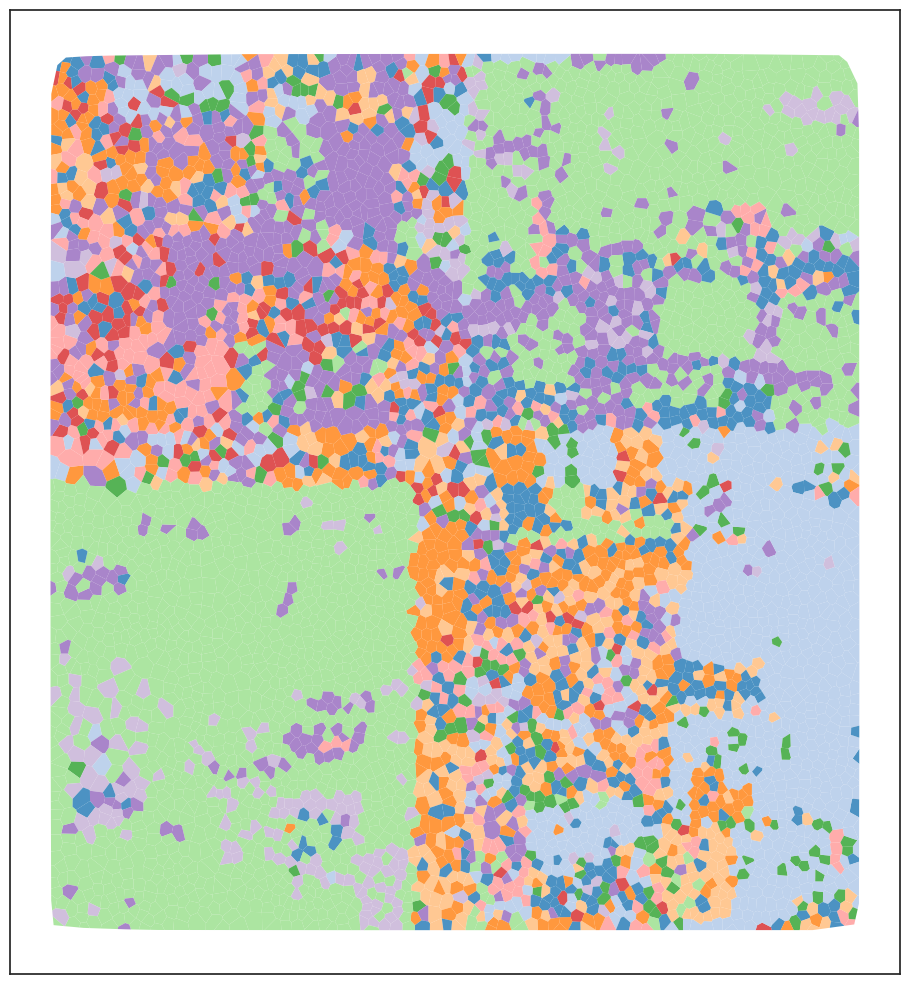

In [149]:
fig, ax = plt.subplots(figsize=(10,10))
sm.pl.voronoi(adata, x_lim = [8000,8500], y_lim=[4000,4500], 
              color_by='cluster_kmeans_new_lda', 
              x_coordinate='X_centroid', y_coordinate='Y_centroid',
              imageid='core_id', subset='35',
                 voronoi_edge_color = 'black',
                 voronoi_line_width = 0, 
                 voronoi_alpha = 0.8, 
                 size_max=3000,
                 overlay_points=None, 
                 plot_legend=True, 
                 legend_size=6, **{'ax':ax})

In [150]:
adata.write("xenium_filter_annotated_checkpoint.h5ad")